In [1]:
import pandas as pd
import nasdaqdatalink
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


nasdaqdatalink.ApiConfig.api_key = 'zxLNKQydu_qNXQ2tZ7vz'

etf_symbols = ["VCSH", "HYG"]

# etf_symbols = [
#     "SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "BND", "VTV", "IEFA", "VUG",
#     "AGG", "IWF", "VWO", "IEMG", "IJH", "VIG", "IJR", "VXUS", "GLD", "VGT",xs
#     "VO", "BNDX", "XLK", "IWM", "IWD", "SCHD", "VYM", "EFA", "ITOT", "TLT",
#     "VB", "RSP", "BIL", "XLV", "VCIT", "XLE", "MUB", "IVW", "VCSH", "VEU",
#     "QUAL", "SCHX", "BSV", "SCHF", "IXUS", "LQD", "IWB", "VTEB", "JEPI", "VNQ",
#     "XLF", "VT", "DIA", "VV", "USMV", "IEF", "SHY", "MBB", "IWR", "IAU",
#     "IVE", "DGRO", "VBR", "GOVT", "SCHB", "JPST", "VGSH", "IUSB", "SPLG", "DFAC",
#     "IGSB", "SHV", "VGIT", "SCHG", "TIP", "SPYG", "SDY", "USFR", "SGOV", "MDY",
#     "ACWI", "DVY", "TQQQ", "VMBS", "VGK", "SPYV", "EEM", "XLY", "EFV", "SPDW",
#     "COWZ", "VHT", "BIV", "XLP", "QQQM", "VONG", "HYG", "MGK", "VXF", "VOE"
# ]

In [2]:
# Initialize an empty DataFrame for combined prices
combined_prices_df = pd.DataFrame()

# Iterate over each ETF in your universe
for ticker in etf_symbols:
    # Fetch the data
    prices = nasdaqdatalink.get_table('SHARADAR/SFP', qopts={"columns":['date', 'closeadj']}, date={'gte':'2020-11-13'}, ticker=ticker)
    
    # Create DataFrame and calculate log returns
    prices_df = pd.DataFrame(prices[::-1])
    prices_df.set_index('date', inplace=True)  # Set 'date' as index

    # Add this ETF's adjusted close prices to the combined DataFrame
    combined_prices_df[ticker] = prices_df['closeadj']

# Drop rows with any NaN values to ensure all series are aligned
combined_prices_df.dropna(inplace=True)

combined_prices_df.to_csv("etf.csv", index=True)


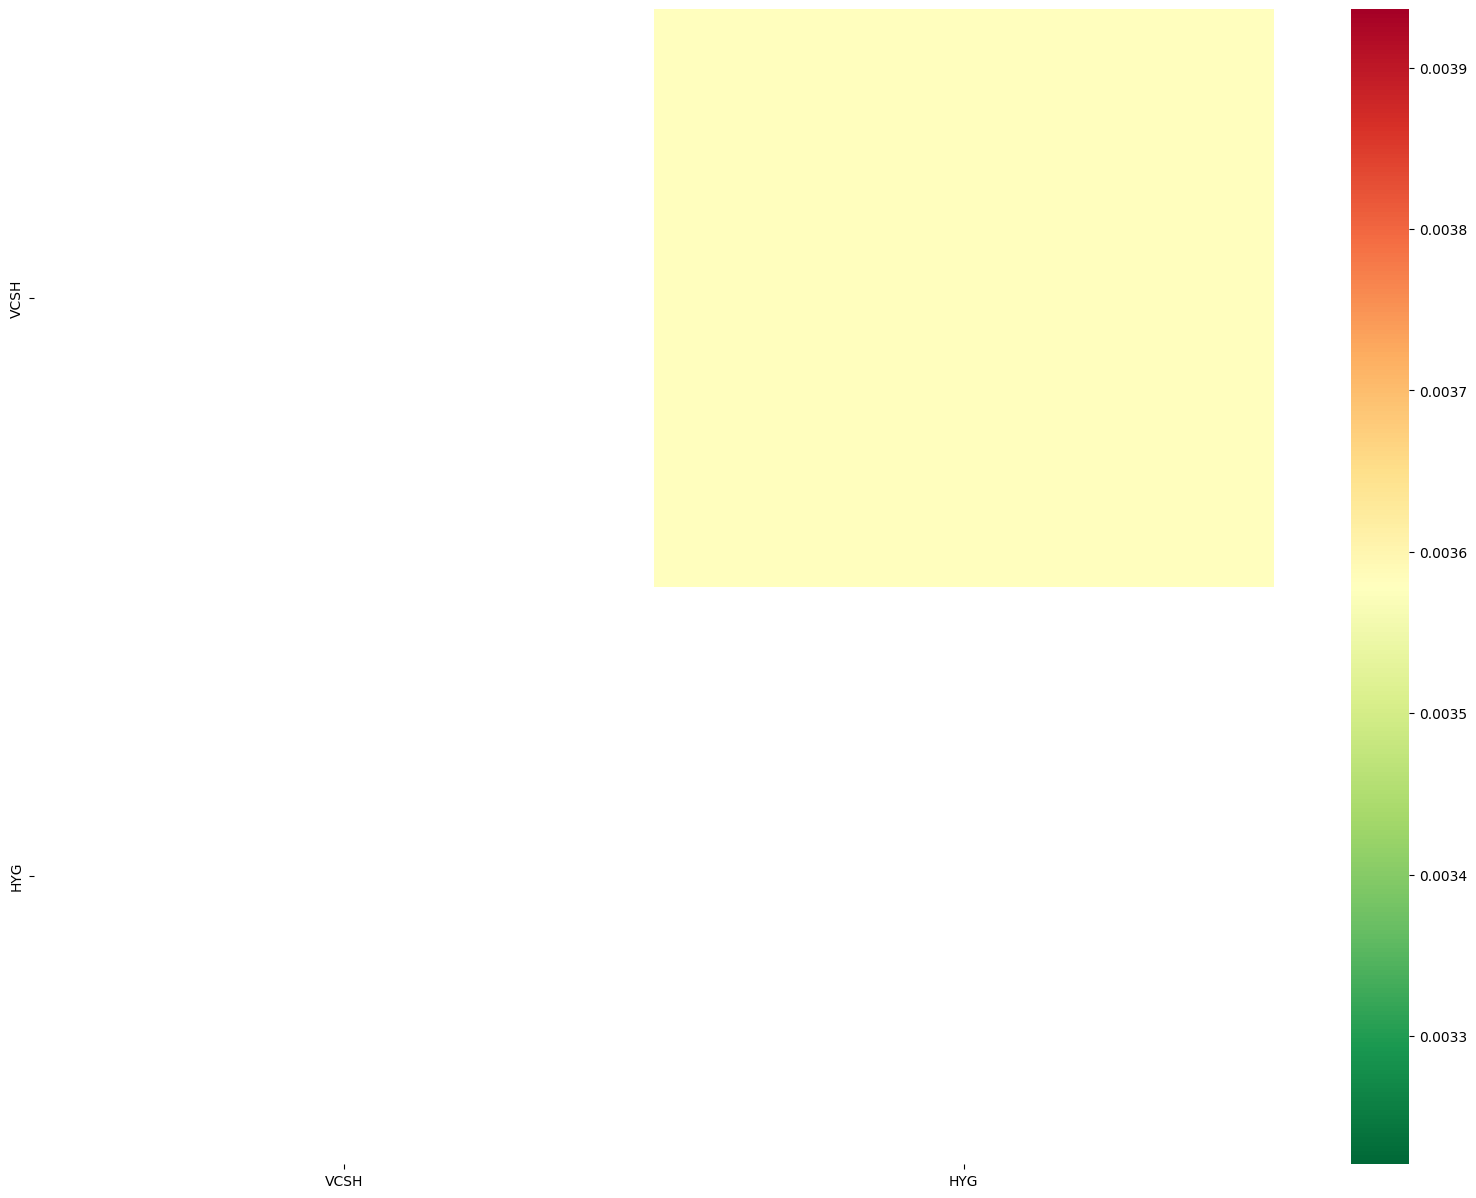

[('VCSH', 'HYG')]


In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            if len(S1) != len(S2):
                print(f"Mismatch for pairs: {keys[i]} and {keys[j]}")
                continue

            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


# Assuming combined_prices_df is already defined and structured correctly
scores, pvalues, pairs = find_cointegrated_pairs(combined_prices_df)


# Adjust the figure size
plt.figure(figsize=(20, 15))

# Plotting the heatmap
sns.heatmap(pvalues, xticklabels=combined_prices_df.columns, yticklabels=combined_prices_df.columns, cmap='RdYlGn_r', mask=(pvalues >= 0.05))

# Display the plot
plt.show()

print(pairs)

### Set Algorithm Params

In [4]:
# Algorithm Params
lookback_window = 100 # used for regression
zscore_window = 30 # used for zscore calculation, must be less than lookback_window

upper_threshold = 2
lower_threshold = -2
symbol_one = "VCSH"
symbol_two = "HYG"


### Data Fetching

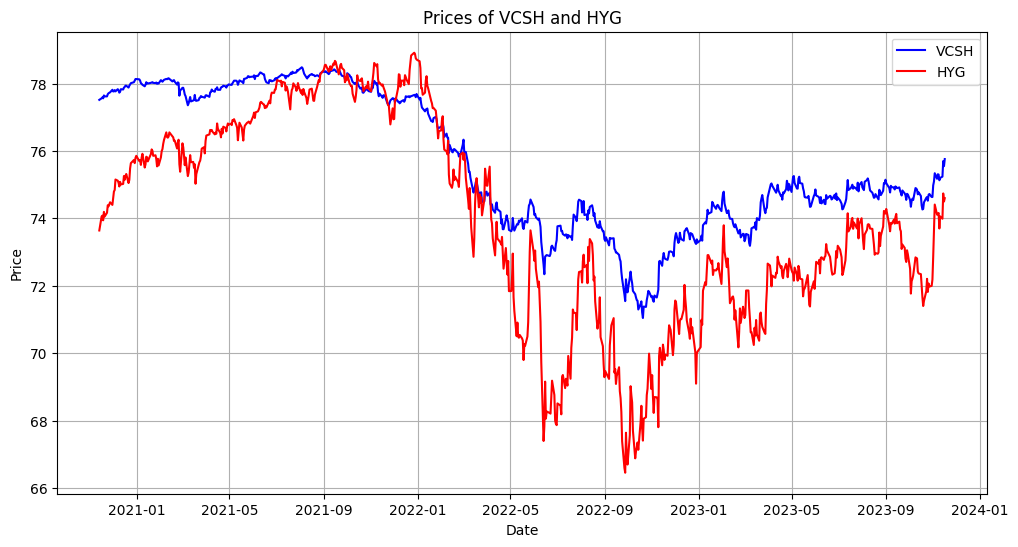

1.4087260546392277


In [5]:
# Here we can either get fresh data or use combined 

selected_pair = combined_prices_df[[symbol_one, symbol_two]]
x = selected_pair[symbol_one]
y = selected_pair[symbol_two]

# Plotting the prices
plt.figure(figsize=(12, 6))
plt.plot(selected_pair.index, selected_pair[symbol_one], label=symbol_one, color='blue')
plt.plot(selected_pair.index, selected_pair[symbol_two], label=symbol_two, color='red')
plt.title(f"Prices of {symbol_one} and {symbol_two}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Perform linear regression
model = sm.OLS(y, sm.add_constant(x)).fit()
hedge_ratio = model.params[1]

print(hedge_ratio)



### Calculate Spread, Z-Score

In [6]:

# Calculate the spread using the new hedge ratio
selected_pair['calculated_spread'] = selected_pair[symbol_two] - hedge_ratio * selected_pair[symbol_one]

# Calculate the rolling mean, standard deviation, and z-score
selected_pair['rolling_mean_spread'] = selected_pair['calculated_spread'].rolling(window=zscore_window).mean()
selected_pair['rolling_std_spread'] = selected_pair['calculated_spread'].rolling(window=zscore_window).std()
selected_pair['z_score'] = (selected_pair['calculated_spread'] - selected_pair['rolling_mean_spread']) / selected_pair['rolling_std_spread']



### Calculate Trading Signals

/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_12472/3388464512.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]
/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_12472/3388464512.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]
/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_12472/3388464512.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

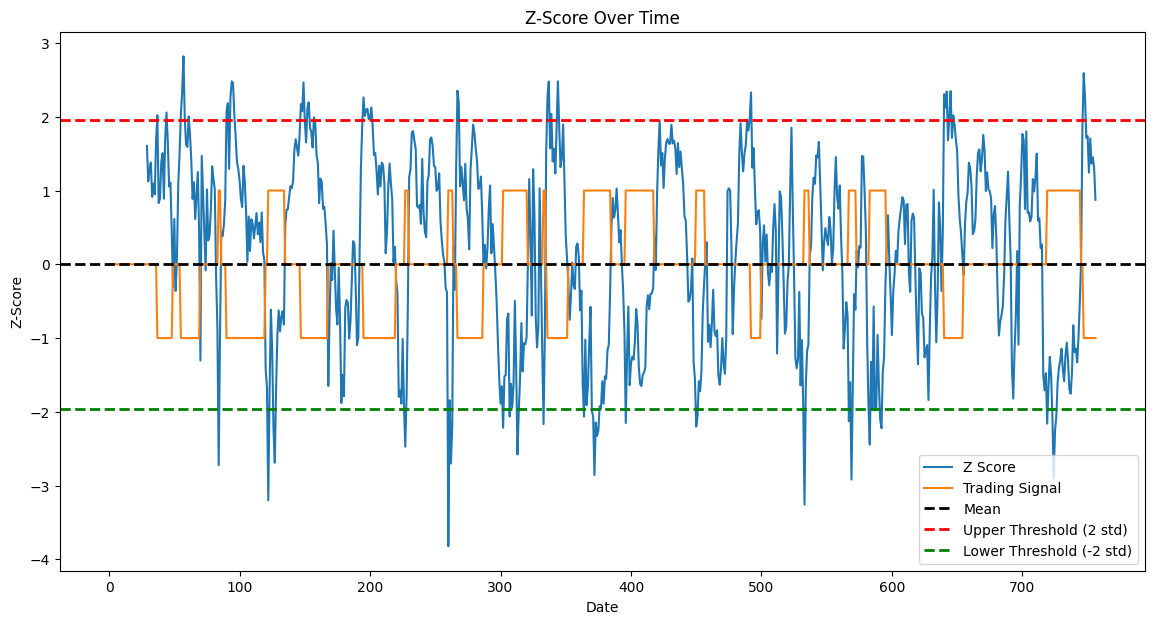

SHARPE RATIO:  -2.929054361600282


In [7]:
selected_pair['trading_signal'] = 0
selected_pair['symbol_one_position'] = 0
selected_pair['symbol_two_position'] = 0
selected_pair['portfolio_value'] = 10000

current_position = 0

selected_pair = selected_pair.reset_index(drop=True)

for i in range(1, len(selected_pair)):

    # If z-score crosses below lower threshold, go long
    if selected_pair['z_score'].iloc[i] < lower_threshold and selected_pair['z_score'].iloc[i-1] >= lower_threshold:
        selected_pair['trading_signal'].iloc[i] = 1

    # If z-score crosses above upper threshold, go short
    elif selected_pair['z_score'].iloc[i] > upper_threshold and selected_pair['z_score'].iloc[i-1] <= upper_threshold:
        selected_pair['trading_signal'].iloc[i] = -1

    # If z-score crosses the zero line from above or below, go neutral
    elif (selected_pair['z_score'].iloc[i] < 0 and selected_pair['z_score'].iloc[i-1] > 0) or \
            (selected_pair['z_score'].iloc[i] > 0 and selected_pair['z_score'].iloc[i-1] < 0):
        selected_pair['trading_signal'].iloc[i] = 0

    # Else, maintain the previous signal
    else:
        selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]


# Plot the z_score
plt.figure(figsize=(14, 7))
plt.plot(selected_pair.index, selected_pair['z_score'], label='Z Score')
plt.plot(selected_pair.index, selected_pair['trading_signal'], label='Trading Signal')
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Mean')
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='Upper Threshold (2 std)')
plt.axhline(-1.96, color='green', linestyle='--', linewidth=2, label='Lower Threshold (-2 std)')
plt.title('Z-Score Over Time')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend(loc='best')
plt.show()

entry_tracking = {
    symbol_one: {
        'units': 0,
        'price': 0,
    },
    symbol_two: {
        'units': 0,
        'price': 0
    },
    'portfolio_entry_value': 10000
}

for index, row in selected_pair.iterrows():

    # Skip the first row
    if index == 0:
        continue
    
    trading_signal = row['trading_signal']
    z_score = row['z_score']
    symbol_one_price = row[symbol_one] 
    symbol_two_price = row[symbol_two]  
    portfolio_value = selected_pair.at[index - 1, 'portfolio_value']
    
    # When we stay neutral
    if current_position == 0 and trading_signal == 0:
        
        # Maintaining Parameters from previous row
        selected_pair.at[index, 'symbol_one_position'] =  selected_pair.at[index - 1, 'symbol_one_position'] 
        selected_pair.at[index, 'symbol_two_position'] =  selected_pair.at[index - 1, 'symbol_two_position'] 
        selected_pair.at[index, 'portfolio_value'] =  selected_pair.at[index - 1, 'portfolio_value']  
        
    # Buy Symbol One, Short Symbol Two Condition (LONG SPREAD)
    if current_position == 0 and trading_signal == 1:

        # Allocate according to half of portfolio_value
        allocate = portfolio_value / 2
        symbol_one_long_qty = allocate / symbol_one_price
        symbol_two_short_qty = symbol_one_long_qty
        selected_pair.at[index, 'symbol_one_position'] = symbol_one_long_qty
        selected_pair.at[index, 'symbol_two_position'] = -symbol_two_short_qty

        # portfolio value shouldnt change
        selected_pair.at[index, 'portfolio_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # Update entry tracking
        entry_tracking[symbol_one]['units'] = symbol_one_long_qty
        entry_tracking[symbol_one]['price'] = symbol_one_price

        entry_tracking[symbol_two]['units'] = symbol_two_short_qty
        entry_tracking[symbol_two]['price'] = symbol_two_price

        # Update portfolio entry value, we entered a position, record our entry portfolio value
        entry_tracking['portfolio_entry_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # update current position 
        current_position = 1

     # Short Symbol One, Buy Symbol Two Condition (SHORT SPREAD)
    elif current_position == 0 and trading_signal == -1:

        # Allocate according to half of portfolio_value
        allocate = portfolio_value / 2
        symbol_one_short_qty = allocate / symbol_one_price
        symbol_two_long_qty = symbol_one_short_qty

        selected_pair.at[index, 'symbol_one_position'] = -symbol_one_short_qty
        selected_pair.at[index, 'symbol_two_position'] = symbol_two_long_qty


        # portfolio value shouldnt change
        selected_pair.at[index, 'portfolio_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # Update entry tracking
        entry_tracking[symbol_one]['units'] = symbol_one_short_qty
        entry_tracking[symbol_one]['price'] = symbol_one_price

        entry_tracking[symbol_two]['units'] = symbol_two_long_qty
        entry_tracking[symbol_two]['price'] = symbol_two_price

        # Update portfolio entry value, we entered a position, record our entry portfolio value
        entry_tracking['portfolio_entry_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # update current position 
        current_position = -1

    # If we are maintaining a long or short spread position, logic should be the same
    elif (current_position == 1 and trading_signal == 1) or (current_position == -1 and trading_signal == -1):

        # Maintaining Parameters from previous row
        selected_pair.at[index, 'symbol_one_position'] =  selected_pair.at[index - 1, 'symbol_one_position'] 
        selected_pair.at[index, 'symbol_two_position'] =  selected_pair.at[index - 1, 'symbol_two_position'] 

        # Updating portfolio value with current prices
        portfolio_entry_value = entry_tracking['portfolio_entry_value'] 

        # Long Symbol One and Short Symbol Two
        if trading_signal == 1:

            # Long case. Gains would be current - entry
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_current_value - symbol_one_entry_value

            # Short case Gains would be entry - current
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_entry_value - symbol_two_current_value

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain

        # Short Symbol One and Long Symbol Two
        if trading_signal == -1:
            
            # Short case Gains would be entry - current
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_entry_value - symbol_one_current_value

            # Long case. Gains would be current - entry
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_current_value - symbol_two_entry_value

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain

    # Go Neutral
    elif current_position != 0 and trading_signal == 0:
        
        # Update Portfolio Value once we've exited positions
        if current_position == 1:

            # Long case. Gains would be current - entry
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_current_value - symbol_one_entry_value

            # Short case Gains would be entry - current
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_entry_value - symbol_two_current_value

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain

        if current_position == -1:
            
            # Short case Gains would be entry - current
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_entry_value - symbol_one_current_value

            # Long case. Gains would be current - entry
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_current_value - symbol_two_entry_value

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain


        # Update positions, since at this point we have exited
        selected_pair.at[index, 'symbol_one_position'] = 0
        selected_pair.at[index, 'symbol_two_position'] = 0

        # update current position 
        current_position = 0
        

selected_pair['returns'] = np.log(selected_pair['portfolio_value'] / selected_pair['portfolio_value'].shift(1))
selected_pair.to_csv("result_no_hedge.csv", index=True)


def sharpe_ratio(df, risk_free_rate=0.03):
    # Calculate the mean of daily returns
    expected_return = df['returns'].mean() * 252  # Annualize the expected return

    # Calculate the standard deviation (volatility) of daily returns and annualize it
    volatility = df['returns'].std() * (252 ** 0.5)

    # Calculate the Sharpe Ratio
    return (expected_return - risk_free_rate) / volatility

print("SHARPE RATIO: ", sharpe_ratio(selected_pair))

def calculate_cagr(final_value, initial_value, number_of_years):
    return (final_value / initial_value) ** (1 / number_of_years) - 1

# Example usage:
# initial_value = 1000000  # example initial value
# final_value = 1100283   # example final value
# number_of_years = 3    # example duration in years

# cagr = calculate_cagr(final_value, initial_value, number_of_years)

# print("CAGR: ", cagr)



        
